In [1]:
here::i_am("SHARE/code/NHV.ipynb")
# setwd("~/SHARE/code/")
library(here)
library(dplyr)
library(TMB)
library(haven)
devtools::load_all('~/Code/R/ktools/')
options(ggplot2.discrete.fill = okabe, ggplot2.discrete.color = okabe)
lilagruen <- c("#D6CEE1", "#CFE9C7")

to_phi <- function(thetas) {
    psi <- phi <- numeric(2)
    psi[1] = 2. * exp(thetas[1]) / (1. + exp(thetas[1])) - 1.
    psi[2] = 2. * exp(thetas[2]) / (1. + exp(thetas[2])) - 1.
    phi[2] = psi[2]
    phi[1] = psi[1] * (1. - phi[2])
    if (phi[2] == -1.) phi[2] = phi[2] + 1e-11
    if (phi[2] == 1. - abs(phi[1])) phi[2] = phi[2] - 1e-11
    phi
}

here() starts at /home/fuchs/fias/knguyen


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


ℹ Loading ktools
Re-compiling ktools



─  installing *source* package ‘ktools’ ... (394ms)
   ** using staged installation
─  DONE (ktools)


Warning message in system("unar -v", intern = FALSE):
“error in running command”


In [2]:
W <- readRDS("SHARE/data/Www.rds") %>%
    mutate(country = haven::as_factor(country))

Truncated

In [94]:
W %>% 
    group_by(wave) %>%
    summarise(max(accessed))

wave,max(accessed)
<chr>,<dbl+lbl>
1,98
2,98
3,98
4,98
5,365
6,366
7,365
8,5
9,5


## German data test

In [99]:
W %>%
    filter(
        country == "Germany", 
        accessed >= 0, 
        yrbirth > 1900, 
        doccd >= 0, 
        int_year > 2000
    ) %>%
    mutate(across(where(is.labelled), as.double)) %>%
    mutate(aai = int_year - yrbirth) %>%
    filter(aai > 49, aai < 102) %>%
    dplyr::select(
        mergeid, 
        accessed, 
        aai, 
        wave, 
        gender, 
        yrbirth, 
        pm, 
        doccd
    ) %>%
    slice_sample(n = 5000) %>%
    mutate(
        bch = yrbirth - min(yrbirth),
        aai = aai - min(aai),
        idx = as_numeric(mergeid), 
        I = case_when(
            wave > 7 ~ 1, 
            wave %in% c(1:4) & accessed == 98 ~ 1, 
            otherwise ~ 0
        ),
        accessed = case_when(
            I == 1 & accessed == 5 ~ 0,
            otherwise ~ accessed
        )
    ) %>%
    allot(deu_mod)

In [100]:
deu_mod %>% filter(I == 1) %>% count(accessed)

accessed,n
<dbl>,<int>
0,51
1,425
98,14


In [150]:
# cd("SHARE/code")
tmb_load("poigamma", nthreads = 10)

Note: Using Makevars in /home/fuchs/fias/knguyen/.R/Makevars 


$trace.atomic
[1] 0

$trace.optimize
[1] 0

$nthreads
[1] 10

$trace.parallel
[1] 0

$tmbad.atomic_sparse_log_determinant
[1] 1

$tape.parallel
[1] 0

$optimize.parallel
[1] 0

$autopar
[1] 0

$optimize.instantly
[1] 1

$debug.getListElement
[1] 0

$tmbad.sparse_hessian_compress
[1] 0

In [151]:
X <- model.matrix(~ I + doccd + factor(gender) + aai + bch, deu_mod)
head(X)

,(Intercept),I,doccd,factor(gender)2,aai,bch
1,1,0,2,1,11,52
2,1,1,2,0,33,29
3,1,0,3,1,28,28
4,1,0,2,1,8,48
5,1,0,4,1,33,29
6,1,0,0,0,2,45


Init for AR2

In [152]:
init <- list(
    betas = rep(0, ncol(X)),
    log_alpha = log(2),
    gamma = rep(1, nrow(deu_mod)),
    log_alpha_prior = log(c(shape = 1e-2, scale = 1e2))
)

In [153]:
data <- list(
    y = deu_mod$accessed,
    X = X,
    E = deu_mod$pm, 
    I = deu_mod$I,
    betas_prior = c(0, 1)
)

In [154]:
obj <- TMB::MakeADFun(
    data, 
    init,
    random = 'gamma',
    DLL = "poigamma", 
    silent = T
)
fit <- nlminb(obj$par, obj$fn, obj$gr, control = list(trace = 0))

Warning message in nlminb(obj$par, obj$fn, obj$gr, control = list(trace = 0)):
“NA/NaN function evaluation”
Warning message in nlminb(obj$par, obj$fn, obj$gr, control = list(trace = 0)):
“NA/NaN function evaluation”
Warning message in nlminb(obj$par, obj$fn, obj$gr, control = list(trace = 0)):
“NA/NaN function evaluation”


In [155]:
rp <- sdreport(obj, ignore.parm.uncertainty	= F)

In [156]:
(srp <- summary(rp, 'fixed'))

,Estimate,Std. Error
betas,-2.58784937,0.154032163
betas,-0.64344109,0.156540975
betas,0.26207162,0.008613899
betas,0.01280005,0.023819163
betas,0.03447873,0.003050223
betas,0.02916116,0.002875815
log_alpha_prior,-4.50787669,5.619506553
log_alpha_prior,4.60573280,8.330212928
log_alpha,0.56356039,0.022706506


In [159]:
srp[1:6, 1] %>%
    exp() %>%
    `names<-`(colnames(X)) %>%
    print(digits = 4)

    (Intercept)               I           doccd factor(gender)2             aai 
        0.07518         0.52548         1.29962         1.01288         1.03508 
            bch 
        1.02959 


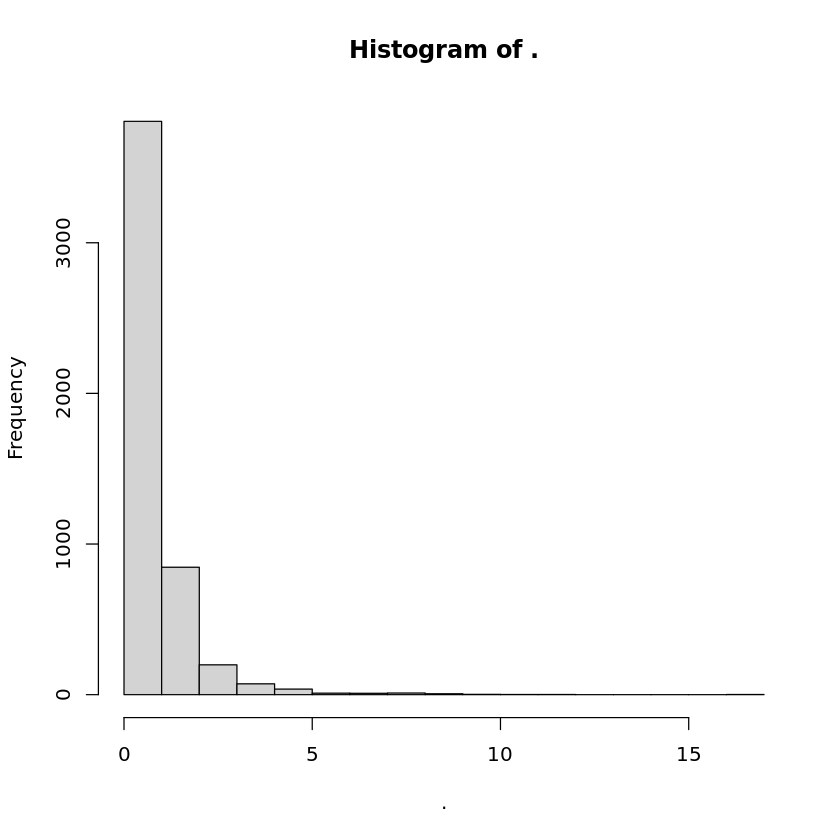

In [160]:
rp_re <- summary(rp, 'random')
rp_re %>%
    as_tibble(rownames = "v") %>%
    filter(v == "gamma") %>%
    pull(Estimate) %>%
    hist()

List of 6
 $ y_new : num [1:5000] 11 0 4 8 8 2 2 7 65 1 ...
 $ alpha : num 1.76
 $ lambda: num [1:5000] 18.263 0.441 5.888 5.57 10.435 ...
 $ ll    : num [1:5000] -3.645 -0.441 -1.83 -1.845 -2.28 ...
 $ betas : num [1:6] -2.5878 -0.6434 0.2621 0.0128 0.0345 ...
 $ gamma : num [1:5000] 4.266 0.179 0.494 0.676 1.322 ...


Warning message in cbind(y_new = c(11, 0, 4, 8, 8, 2, 2, 7, 65, 1, 1, 5, 38, 7, :
“number of rows of result is not a multiple of vector length (arg 5)”


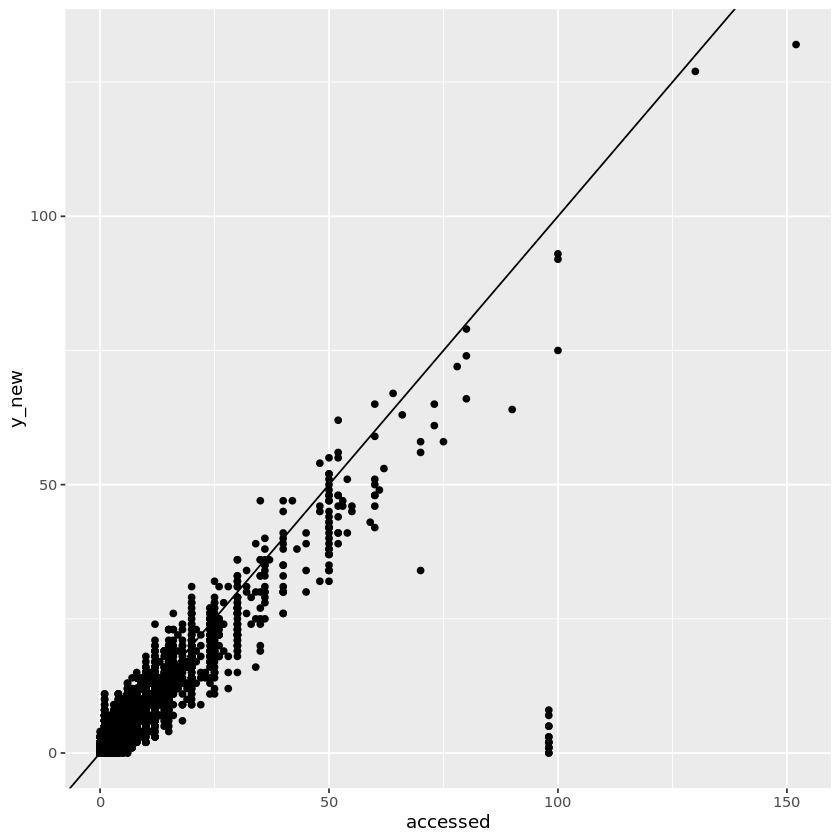

In [161]:
sm <- obj$simulate()
dplyr::glimpse(sm)

sizing(7, 7)
do.call("cbind", sm) %>%
    cbind(deu_mod) %>%
    ggplot(aes(accessed, y_new)) +
    geom_point() +
    geom_abline(aes(intercept = 0, slope = 1))

In [145]:
smp <- ktools::sample_tmb(list(fit = fit, obj = obj), 1000, FALSE)

No taping done.



[1] "Calculating joint precision"
iter: 1  value: 12779.37 mgc: 0.6593532 ustep: 4.371736e-06 
iter: 2  value: 12779.37 mgc: 0.6593415 ustep: 1.069654e-06 
iter: 3  value: 12779.37 mgc: 0.6593386 ustep: 3.544355e-05 
iter: 4  value: 12779.37 mgc: 0.6592432 ustep: 2.369655e-05 
iter: 5  value: 12779.37 mgc: 0.00054818 ustep: 0.002486555 
iter: 6  value: 12779.37 mgc: 0.659185 ustep: 3.903533e-07 
iter: 7  value: 12779.37 mgc: 0.6591839 ustep: 2.829696e-06 
iter: 8  value: 12779.37 mgc: 0.6591763 ustep: 6.961557e-06 
iter: 9  value: 12779.37 mgc: 0.0005700648 ustep: 0.0001712898 
iter: 10  value: 12779.37 mgc: 0.0005696666 ustep: 0.01318646 
iter: 11  value: 12779.37 mgc: 0.659187 ustep: 9.297945e-07 
Not improving much - will try early exit...PD hess?: TRUE 
mgc: 0.0005431904 
outer mgc:  916.5886 
iter: 1  value: 12775.68 mgc: 0.08152252 ustep: 1 
iter: 2  value: 12775.68 mgc: 0.6603877 ustep: 1.749033e-05 
iter: 3  value: 12775.68 mgc: 7.971953e-05 ustep: 0.0002680392 
iter: 4  value:

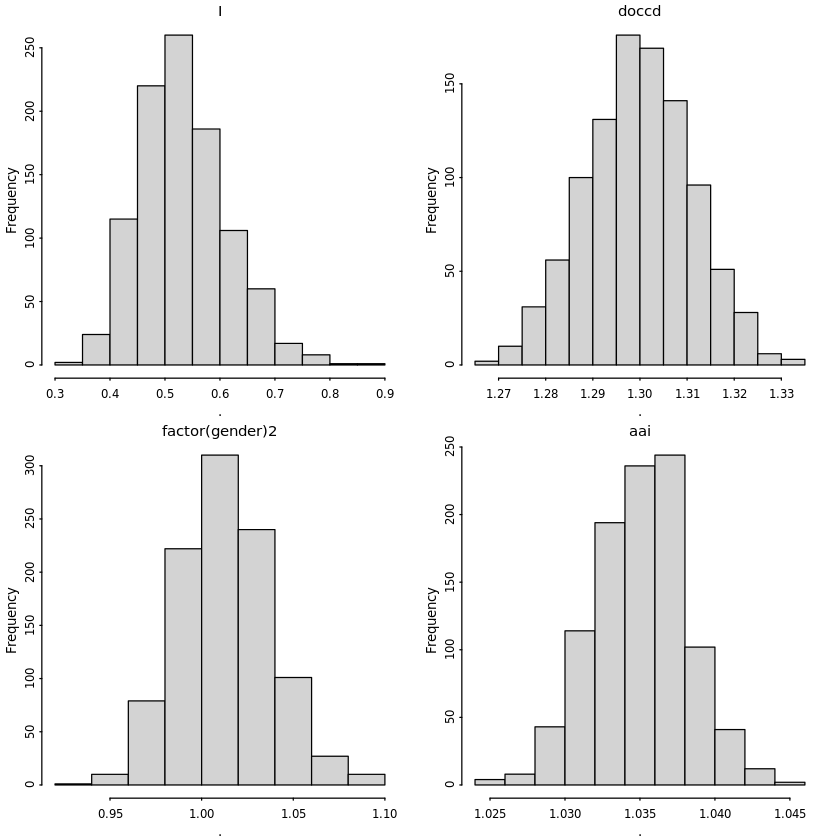

In [163]:
put(2, 2)
for (i in 2:5) {
    smp[, i] %>%
        exp() %>%
        hist(main = colnames(X)[i])
}

In [27]:
tmb_ICs(smp, 'll', looic = F) %>% print()

       DIC      WAIC1      WAIC2 
  77224.04   74102.03 1089075.68 


In [54]:
#automatic document conversion to markdown and then to word
 #first convert the ipython notebook paper.ipynb to markdown
 system("cd code && jupyter nbconvert --to latex --template ~/ipybib.tplx --no-input tmb_works.ipynb")
 #next convert markdown to ms word
 
conversion <- paste0(
    'cd code &&',
    'pandoc -s tmb_works.md -t docx -o tmb_works.docx',
    ' --filter pandoc-citeproc',
    ' --bibliography="/Users/knguyen/Documents/zotero_biblatex.bib"',
    ' --csl="apa.csl"'
 )

system(conversion)
